In [1]:
!pip install torch==1.8 torchtext==0.9.0
!pip install pytorch_lightning
!pip install transformers
!pip install torchmetrics

     |████████████████████████████████| 925 kB 5.7 MB/s 
     |████████████████████████████████| 125 kB 47.4 MB/s 
     |████████████████████████████████| 329 kB 41.2 MB/s 
     |████████████████████████████████| 596 kB 36.1 MB/s 
     |████████████████████████████████| 829 kB 33.6 MB/s 
     |████████████████████████████████| 1.1 MB 26.7 MB/s 
     |████████████████████████████████| 271 kB 47.0 MB/s 
     |████████████████████████████████| 160 kB 47.9 MB/s 
     |████████████████████████████████| 192 kB 41.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=bd907b8974bb539b37ce064c8cdd91202aa493b8d485f13fc6914ad7073ea2f1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from torchmetrics.functional import auroc, accuracy, f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [4]:
df = pd.read_csv('train_intents.csv' )
df = df.drop(columns=['Unnamed: 0','find_bus'], errors='ignore')
LABEL_COLUMNS = [ 'book_hotel', 'book_restaurant', 'book_train', 'find_attraction', 'find_hospital', 'find_hotel', 'find_police', 'find_restaurant', 'find_taxi', 'find_train', 'no_intent']
df

,Unnamed: 0.1,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,0,i need a place to dine in the center thats exp...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,1,"Any sort of food would be fine, as long as it ...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,2,"Sounds good, could I get that phone number? Al...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
3,3,Yes. Can you book it for me?,['find_hotel'],0,0,0,0,0,1,0,0,0,0,0
4,4,i want to book it for 2 people and 2 nights st...,['book_hotel'],1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50833,51239,what is there phone number?,['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0
50834,51240,"no, thank you. Goodbye.",['no_intent'],0,0,0,0,0,0,0,0,0,0,1
50835,51241,"Hello, I am looking for a cheap restaurant tha...",['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0
50836,51242,"Yes, how about portuguese food?",['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0


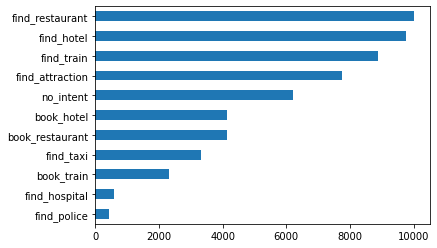

In [124]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

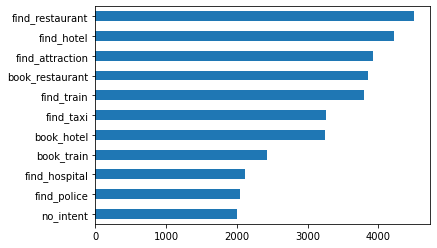

In [9]:
df1 = df.copy()

intentdf = []
for intent in LABEL_COLUMNS:
  intent_sample_df = df1[  (df1[LABEL_COLUMNS].sum(axis=1) == 1) & (df1[intent] == 1)]
  intent_sample_df = intent_sample_df.sample(2000, replace=True)
  intentdf.append( intent_sample_df)

multiple_intent_df = df1[df1[LABEL_COLUMNS].sum(axis=1) > 1]  
train_df = pd.concat([multiple_intent_df, *intentdf])


train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [22]:
train_df, val_df = train_test_split(train_df, test_size=0.05)
train_df.shape, val_df.shape

((27255, 14), (1435, 14))

In [ ]:
#train_df = train_df.sample(5000)

In [11]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
class MultiWOZIntentDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [24]:
train_dataset = MultiWOZIntentDataset(train_df, tokenizer)

In [25]:
class MultiWOZIntentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = MultiWOZIntentDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = MultiWOZIntentDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [26]:
N_EPOCHS = 3
BATCH_SIZE = 12
MAX_TOKEN_COUNT  = 128
data_module = MultiWOZIntentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)
data_module.setup()

# Model

In [27]:
class IntentClassifier(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
     
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [28]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1362, 6813)

In [29]:
model = IntentClassifier(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)


logger = TensorBoardLogger("bert-lightning_logs", name="intent-classification")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [34]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 8.5 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 2271: val_loss reached 0.12385 (best 0.12385), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 4543: val_loss reached 0.10930 (best 0.10930), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 6815: val_loss reached 0.10316 (best 0.10316), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [35]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10316207259893417}
--------------------------------------------------------------------------------


[{'test_loss': 0.10316207259893417}]

In [58]:
trained_model = IntentClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
#torch.save(trained_model.state_dict(), "bert_multiwoz.pth")

# Predictions

In [66]:
test_text = " Звучит хорошо, могу я узнать этот номер телефона?"
encoding = tokenizer.encode_plus(
  test_text,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

book_hotel: 0.006832662969827652
book_restaurant: 0.0318518690764904
book_train: 0.029266605153679848
find_attraction: 0.055040471255779266
find_hospital: 0.00576367462053895
find_hotel: 0.004831911064684391
find_police: 0.0019055361626669765
find_restaurant: 0.04084542393684387
find_taxi: 0.6008405685424805
find_train: 0.17952053248882294
no_intent: 0.0060520898550748825


In [65]:
THRESHOLD = 0.4
test_comment = " Звучит хорошо, могу я узнать этот номер телефона?"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

find_taxi: 0.6008405685424805


# Evaluation on original test data

In [40]:
val_df = pd.read_csv('test_intents.csv' )
val_df = val_df.drop(columns=['Unnamed: 0','find_bus'], errors='ignore')

val_df

,Unnamed: 0.1,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,0,i need a place to dine in the center thats exp...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,1,"Any sort of food would be fine, as long as it ...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,2,"Sounds good, could I get that phone number? Al...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
3,3,Yes. Can you book it for me?,['find_hotel'],0,0,0,0,0,1,0,0,0,0,0
4,4,i want to book it for 2 people and 2 nights st...,['book_hotel'],1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,6838,I would like to visit a cinema of the west side.,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6798,6839,How about a museum then?,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6799,6840,I would prefer a museum. One with free entry i...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6800,6841,That is fine. Book me a ticket and get me a re...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = MultiWOZIntentDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/6802 [00:00<?, ?it/s]

In [42]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9695)

In [43]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
book_hotel: 0.944267749786377
book_restaurant: 0.9546239972114563
book_train: 0.9496142268180847
find_attraction: 0.976103663444519
find_hospital: 0.9766295552253723
find_hotel: 0.9578602910041809
find_police: 0.9978116750717163
find_restaurant: 0.9523100852966309
find_taxi: 0.9903485774993896
find_train: 0.97664475440979
no_intent: 0.9921751022338867


In [44]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                 precision    recall  f1-score   support

     book_hotel       0.87      0.70      0.78       551
book_restaurant       0.86      0.76      0.81       544
     book_train       0.83      0.73      0.77       281
find_attraction       0.89      0.82      0.86      1083
  find_hospital       0.55      0.88      0.67        65
     find_hotel       0.89      0.78      0.83      1265
    find_police       0.66      0.93      0.77        43
find_restaurant       0.86      0.77      0.82      1313
      find_taxi       0.91      0.84      0.87       461
     find_train       0.91      0.86      0.88      1111
      no_intent       0.93      0.94      0.93       946

      micro avg       0.88      0.81      0.85      7663
      macro avg       0.83      0.82      0.82      7663
   weighted avg       0.88      0.81      0.84      7663
    samples avg       0.86      0.84      0.84      7663



# Evaluating on Russian Text Data

In [104]:
val_df = pd.read_csv('Russain_intent_test.csv' )
val_df = val_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','find_bus'], errors='ignore')
LABEL_COLUMNS = [ 'book_hotel', 'book_restaurant', 'book_train', 'find_attraction', 'find_hospital', 'find_hotel', 'find_police', 'find_restaurant', 'find_taxi', 'find_train', 'no_intent']
val_df

,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,"Мне нужно место, чтобы поужинать в центре, это...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,"Любая еда будет в порядке, пока это немного до...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,"Звучит хорошо, могу ли я получить этот номер т...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
3,да.Можете ли вы забронировать это для меня?,['find_hotel'],0,0,0,0,0,1,0,0,0,0,0
4,Я хочу забронировать его для 2 человек и 2 ноч...,['book_hotel'],1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,Я хотел бы посетить кинотеатр западной стороны.,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6798,Как насчет музея тогда?,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6799,Я бы предпочел музей.Один с бесплатной записью...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6800,Это нормально.Забронируйте мне билет и получит...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0


In [105]:
val_df.iloc[1].text

'Любая еда будет в порядке, пока это немного дорого.Могу ли я получить номер телефона для вашей рекомендации?'

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = MultiWOZIntentDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/6802 [00:00<?, ?it/s]

In [120]:
THRESHOLD =.5

In [121]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.8777)

In [122]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
book_hotel: 0.5747591257095337
book_restaurant: 0.7721182703971863
book_train: 0.5234929323196411
find_attraction: 0.6359256505966187
find_hospital: 0.7550998330116272
find_hotel: 0.5536292791366577
find_police: 0.5884952545166016
find_restaurant: 0.6413134932518005
find_taxi: 0.5784802436828613
find_train: 0.5250480771064758
no_intent: 0.7884896397590637


In [123]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                 precision    recall  f1-score   support

     book_hotel       0.40      0.00      0.01       551
book_restaurant       0.32      0.28      0.30       544
     book_train       0.00      0.00      0.00       281
find_attraction       0.85      0.03      0.06      1083
  find_hospital       0.75      0.05      0.09        65
     find_hotel       0.74      0.01      0.02      1265
    find_police       0.00      0.00      0.00        43
find_restaurant       0.76      0.01      0.02      1313
      find_taxi       0.09      0.33      0.14       461
     find_train       0.94      0.03      0.06      1111
      no_intent       1.00      0.00      0.00       946

      micro avg       0.18      0.05      0.08      7663
      macro avg       0.53      0.07      0.06      7663
   weighted avg       0.70      0.05      0.06      7663
    samples avg       0.05      0.05      0.05      7663

